# Principle Component Analysis (PCA)

You have a dataset matrix X with shape `n_samples × n_features`

Each row is one sample (one image, one patient, one student, …).
Each column is one feature (pixel intensity, voxel feature, lab value, …).

PCA finds new axes (new features) that:
- are linear combinations of the original features,
- are uncorrelated with each other,
- and capture as much variance (spread of data) as possible.

## 1. Load digits dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [ ]:
iris = load_iris()
X = iris.data.astype(np.float32)
y = iris.target.astype(int)

X.shape, y.shape

((150, 4), (150,))

In [4]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [5]:
X[:5], y[:5]

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2]], dtype=float32),
 array([0, 0, 0, 0, 0]))

## 2. Implement from scratch

### Step 1: Center the data

PCA looks for directions of maximum variance around the origin. If you don’t center, the “largest variance direction” gets distorted by the offset (the mean).

Output: X with mean=0 and std=1

In [1]:
def center_data(X):
    mean = X.mean(axis=1, keepdims=True)
    return X - mean

In [6]:
X_c = center_data(X)
X_c.shape

(150, 4)

In [7]:
print(f"Before centering: mean={X.mean():.4f}, std={X.std():.4f}")
print(f"After centering: mean={X_c.mean():.4f}, std={X_c.std():.4f}")

Before centering: mean=3.4645, std=1.9738
After centering: mean=0.0000, std=1.8139


### Step 2: Compute covariance matrix

The covariance matrix summarizes all variance + correlation structure.

Output: a matrix of shape `(n_features, n_features)`

In [8]:
def compute_covariance_matrix(X):
    n_samples = X.shape[0]
    covariance_matrix = (X.T @ X) / (n_samples -1)
    return covariance_matrix

In [9]:
cov_matrix = compute_covariance_matrix(X_c)
cov_matrix.shape

(4, 4)

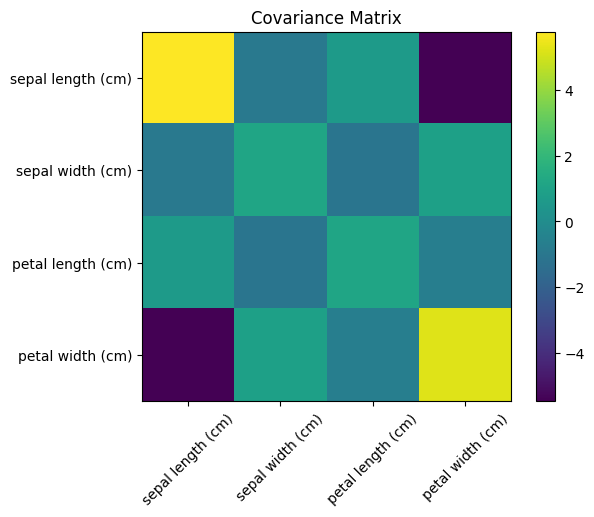

In [10]:
# Plot covariance matrix
plt.imshow(cov_matrix, cmap='viridis')

xticks = iris.feature_names
yticks = iris.feature_names
plt.xticks(range(cov_matrix.shape[0]), xticks, rotation=45)
plt.yticks(range(cov_matrix.shape[0]), yticks)
plt.colorbar()

plt.title("Covariance Matrix")
plt.show()

### Step 3: Find eigenvectors and eigenvalues of the covariance matrix

Solve: `C.eigenvector = eigenvalue.eigenvector`

- `eigenvector` is a direction in feature space -> **principal directions**
- `eigenvalue` is how much **variance** exists along that direction

In [11]:
def get_eigen_decomposition(cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    return eigenvalues, eigenvectors

In [12]:
eigenvalues, eigenvectors = get_eigen_decomposition(cov_matrix)
eigenvalues.shape, eigenvectors.shape # (n_features,), (n_features, n_features)

((4,), (4, 4))

In [13]:
eigenvectors

array([[-0.49999616,  0.47042567,  0.14180867, -0.71315765],
       [-0.5000043 , -0.5237365 ,  0.67547417,  0.13939308],
       [-0.5000039 , -0.4748231 , -0.71657753, -0.10514628],
       [-0.49999565,  0.5281504 , -0.10070533,  0.6789109 ]],
      dtype=float32)

In [14]:
eigenvalues

array([2.9802118e-07, 3.0200761e-02, 1.9537866e+00, 1.1265359e+01],
      dtype=float32)

### Step 4: Sort eigenvalues be descending order anf choose `k` component to keep

In [15]:
sorted_indices = np.argsort(eigenvalues)[::-1] # descending order
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices] # columns are eigenvectors

In [16]:
sorted_indices

array([3, 2, 1, 0])

In [17]:
# Select top k eigenvectors
k = 2
top_k_eigenvectors = sorted_eigenvectors[:, :k]
top_k_eigenvectors.shape

(4, 2)

In [18]:
top_k_eigenvectors

array([[-0.71315765,  0.14180867],
       [ 0.13939308,  0.67547417],
       [-0.10514628, -0.71657753],
       [ 0.6789109 , -0.10070533]], dtype=float32)

### Step 5: Project data into PCA space

In [19]:
# Project data onto top k eigenvectors
X_reduced = X_c @ top_k_eigenvectors
X_reduced.shape

(150, 2)

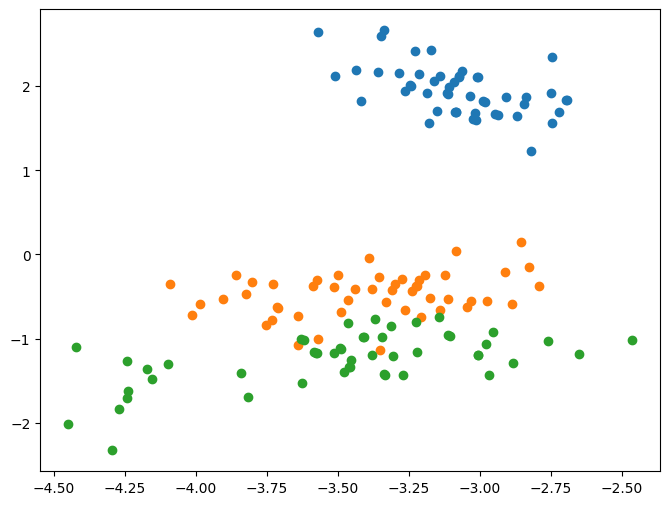

In [20]:
# plot reduced data
plt.figure(figsize=(8,6))
for class_label in np.unique(y):
    plt.scatter(X_reduced[y == class_label, 0], X_reduced[y == class_label, 1], label=iris.target_names[class_label])

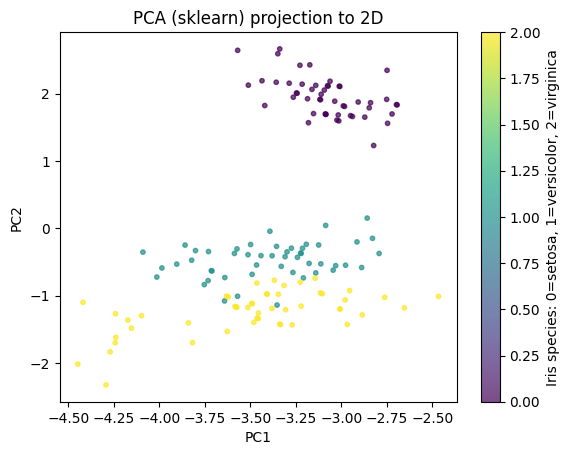

In [21]:
sc = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=10, alpha=0.7)
plt.title("PCA (sklearn) projection to 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")

cb = plt.colorbar(sc)
cb.set_label(f"Iris species: 0={iris.target_names[0]}, 1={iris.target_names[1]}, 2={iris.target_names[2]}")
plt.show()

## 3. Using `sklearn`

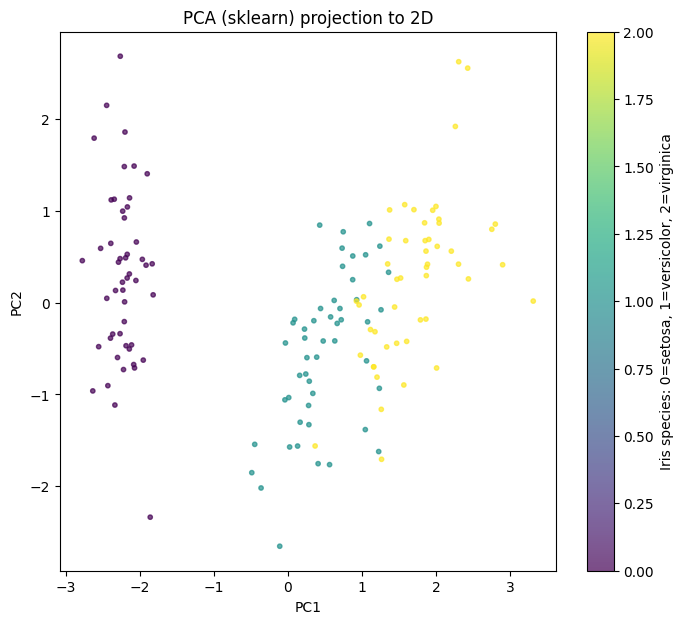

Explained variance ratio (PC1, PC2): [0.72962445 0.2285076 ]
Total variance explained by first 2 PCs: 0.958132


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale features values to have mean=0 and std=1
X_scaled = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 7))
sc = plt.scatter(Z[:, 0], Z[:, 1], c=y, s=10, alpha=0.7)
plt.title("PCA (sklearn) projection to 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")

cb = plt.colorbar(sc)
cb.set_label(f"Iris species: 0={iris.target_names[0]}, 1={iris.target_names[1]}, 2={iris.target_names[2]}")
plt.show()

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)
print("Total variance explained by first 2 PCs:", pca.explained_variance_ratio_.sum())